# Time tracking

- 11/19, 5:30 - 6:00, initial setup, starting scratchwork
- 11/20, 4:45 - 5:30, onto GitHub, got Sinkhorn to run
- 11/21, 3:00 - 4:30, improved Sinkhorn, ran it on MNIST

In [1]:
# Autoreload so we don't have to reimport packages when we change them
%load_ext autoreload
%autoreload 2

In [122]:
## Imports

# Basic
import numpy as np
import matplotlib.pyplot as plt
import random

# My code
import bary

# Data: https://www.tensorflow.org/datasets
import tensorflow_datasets as tfds

# Implementing Sinkhorn

### Basic run

First get it to run on 1D data, and using the differentiability to gradient descent to a fixed measure

In [25]:
# Number of points in 1D
n = 10

# Locations I'll use
x = list(range(n))

# Target measure
## p even though it's not a probability distribution
p = [random.random() for i in range(n)]
p = p / np.sum(p)

# Distance matrix
M = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        M[i,j] = abs(i-j)

In [26]:
l = 10
q = np.zeros(n)
q[0] = sum(p)

bary.sinkhorn(p,q,M,l)

4.467654735839183

In [27]:
# Test
p = np.ones(10) * 0.01
q = np.zeros(10)
p[0] = p[0] + 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = p[3] + 0.4
bary.sinkhorn(p,q,M,30)

1.285901627545571

In [82]:
# Approx ish
# So it passes
0.3 + 2*0.2 + 0.4 + 0.01 * (1 + 0 + 0 + 1 + 2 + 3 + 4 + 5 + 6 + 7)

1.3900000000000001

In [83]:
# Test
p = np.ones(10) * 0.01
q = np.zeros(10)
p[0] = p[0] + 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = p[4] + 0.4
p = p * 5
q = q * 5
bary.sinkhorn(p,q,M,30)

7.049999999999999

Ok, looks like the Sinkhorn code is correct. To do though:
- Edit so r = 0 doesn't throw errors
- Run it on some Google Quick Draw! stuff
- Vectorize better for computing distance of one histogram to many

### Refining it

- $r = 0$ doesn't throw errors
- Iteration can be controlled or is set automatically
- More vectorized

In [33]:
# Test
p = np.zeros(10)
q = np.zeros(10)
p[0] = 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = 0.5
bary.sinkhorn(p,q,M,10,20)

1.1999450296511562

In [30]:
# Wasserstein distance
0.3 * 1 + 0.2 * 2 + 0.5 * 1

1.2

So the $r=0$ and variable number of iterations went through without and issue

Now to vectorize better...

In [35]:
A = np.zeros((3,4))
np.shape(A)

(3, 4)

In [39]:
np.shape(A)[1]

4

In [52]:
# Test
p = np.zeros(10)
q = np.zeros(10)
p[0] = 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = 0.5

In [55]:
Q = np.transpose(np.array([q,q,q,q]))
np.shape(Q)

(10, 4)

In [56]:
bary.sinkhorn(p,Q,M,10,20)

array([1.19994503, 1.19994503, 1.19994503, 1.19994503])

Looks like that's working!

In [74]:
# And scaling things gives expected results
bary.sinkhorn(4*p,4*Q,M,10,20)

array([4.79978012, 4.79978012, 4.79978012, 4.79978012])

## Testing on MNIST

Using TensorFlow for easy data management: https://www.tensorflow.org/datasets/catalog/mnist

In [101]:
# Following this example: https://www.tensorflow.org/datasets/overview

ds = tfds.load('mnist', split='train')
isinstance(ds_train, tf.data.Dataset)

True

In [107]:
# The size of the images
for ex in ds.take(1):
    print(np.shape(ex['image']))

(28, 28, 1)


In [140]:
## Convert to a numpy array of histograms

# Size of histograms
n = 28 * 28

# Number of images to convert
N = 100

# Allocate memory
X = np.zeros((n,N))
y = np.zeros(N)

# Iterate to populate X
i = 0
for ex in ds.take(N):
    # Make sure to normalize too!
    aux = np.ravel(ex['image'].numpy())
    X[:,i] = aux / sum(aux)
    y[i]   = ex['label'].numpy()
    i = i + 1

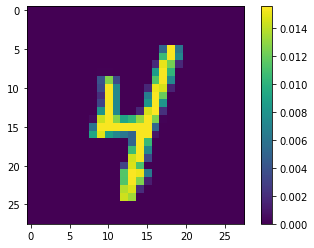

In [143]:
# A quick check that we can recover the original images
img = np.reshape(X[:,0], (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

In [163]:
# Sort things in terms of the labels
sort = np.argsort(y)
y = y[sort]
X = X[:,sort]

In [136]:
# Get M

# To make sure I don't mess up indexing things, I'll set up a list of locations and reshape it into a matrix
# So when I calculate a pairwise distance in the matrix, I can easily associate it to the location in the vector
locations_vec = np.array(range(n))
locations_arr = np.reshape(locations_vec, (28,28))

M = np.zeros((n,n))
# Having 4 "for" loops is a bit embarassing, but I'm not trying to think too hard right now
for i1 in range(28):
    for j1 in range(28):
        for i2 in range(28):
            for j2 in range(28):
                M[locations_arr[i1,j1], locations_arr[i2,j2]] = np.sqrt((i1-i2)**2 + (j1-j2)**2)

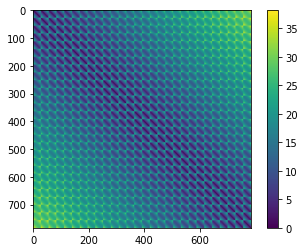

In [138]:
# The plot looks reasonable
plt.imshow(M)
plt.colorbar()
plt.show()

In [164]:
# Compute pairwise sinkhorn divergences

# Using settings from the original Marco Cuturi Sinkhorn paper
l = 9
iterations = 20

K = np.exp(-l * M)

D = np.zeros((N,N))

for i in range(N):
    # Compute the distance from image i to the rest of them
    D[i,:] = bary.sinkhorn_mk(X[:,i],X,M,K,iterations)

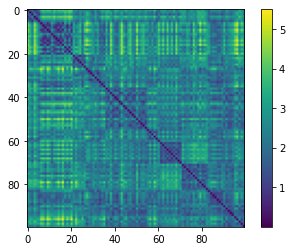

In [165]:
# Plot them
plt.imshow(D)
plt.colorbar()
plt.show()

In [166]:
# Compare to when the digits are equal
B = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        B[i,j] = (y[i] == y[j])

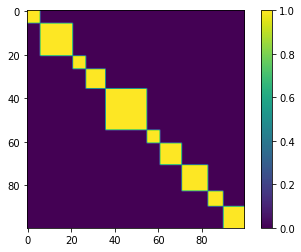

In [167]:
plt.imshow(B)
plt.colorbar()
plt.show()

That looks awesome!

# Differentiability

- Implement the code to calculate gradients of Sinkhorn (maybe start with regularized)
- Test on MNIST data
 - Gradient descent from uniform distribution to a given digit
 - Find an average case digit
- Test on Quick Draw!: https://www.tensorflow.org/datasets/catalog/quickdraw_bitmap

# Clustering

Try to do k-means ish stuff. Ex. "discover" that there are 2 clusters of sevens: with and without the middle line.